## Primeiro Trabalho de Inteligência Artificial e Sistemas Inteligentes
Igor Wandermurem Dummer - 2019109389

# Configurações

In [262]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import Counter

from sklearn import datasets
from sklearn.model_selection import GridSearchCV, cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from sklearn.utils import resample, check_random_state

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

### Load dataset

In [263]:
# Importação da base de dados
df = pd.read_csv('https://raw.githubusercontent.com/VitorBonella/PL-Dataset/main/dataset.csv',sep=";") #Leitura dos dados para o pandas

In [264]:
# Lista de Indices
FOURIER = ['df01', 'df02', 'df03', 'df04','df05', 'df06', 'df07', 'df08', 'df09', 'df10']
HU = ['i1', 'i2', 'i3', 'i4','i5', 'i6', 'i7']
HARALICK = ['probmax', 'energia', 'entropia', 'contraste','homogeneidade', 'correlacao']

# Como minha matrícula é terminada em 9 (especificação), utilizarei 7 descritores de Hu e 6 descritores de Haralick.
ALL = HU + HARALICK

In [265]:
df.set_index('id',inplace=True) #Transformando a coluna id no indice da tabela

# Transformando valores em float
df[ALL] = df[ALL].apply(lambda x: x.str.replace(',', '.').astype(float), axis=1)

#Observem que a classe esta separada em duas colunas então devemos concatenadas para formar uma coluna só chamada classe
df['classe'] = df['tipo_lampada'].str.replace(" ", "") + df['potencia'].astype(str) 

In [266]:
df['classe']

id
355    metalica400
356    metalica400
357    metalica400
358    metalica400
359    metalica400
          ...     
656    metalica250
657    metalica250
658    metalica250
659    metalica250
660    metalica250
Name: classe, Length: 297, dtype: object

In [267]:
df[ALL].head(2)

,i1,i2,i3,i4,i5,i6,i7,probmax,energia,entropia,contraste,homogeneidade,correlacao
id,,,,,,,,,,,,,
355,0.168084,0.000615,0.000131,5.717751e-05,3.808159e-09,-1.417337e-06,3.153370e-09,0.890374,3.170342,6.571618,-30.712990,3.763049,0.000304
356,0.164507,0.001087,0.000043,1.011576e-08,-5.395931e-15,-6.859661e-11,3.907229e-15,0.874335,3.056052,7.561434,-37.105195,3.722622,0.000269


In [268]:
X = df[ALL]
y = df['classe']

## Funções e variáveis úteis

In [269]:
# Valor de split, repeat e estimators utilizados diversas vezes

n_splits = 10
n_repeats = 3
n_estimators = [3,9,15,21]

In [270]:
# Exibe o valor de média, desvio padrão e o intervalo de confiança
def classification_report(scores):
    print(f'Media: {scores.mean():.8f}, Desvio Padrao: {scores.std():.8f}')
    inf, sup = stats.norm.interval(0.95, loc=scores.mean(), 
                               scale=scores.std()/np.sqrt(len(scores)))
    print(f'Intervalo de confiança (95%): [{inf:.8f},{sup:.8f}]')

In [271]:
scores_list = [] # Lista onde será armazenados os scores obtidos pelos classificadores

# Cria e define as colunas da tabela de resultados
result_table = pd.DataFrame(columns=['Método', 'Média', 'Desvio Padrão', 'Limite Inferior', 'Limite Superior'])

In [272]:
# Adicona linhas correspondentes a cada classificador na tabela de resultado
def set_table(result_table, scores, scores_name):
  inf, sup = stats.norm.interval(0.95, loc=scores.mean(), 
                               scale=scores.std()/np.sqrt(len(scores)))
  row = {'Método': [scores_name],
           'Média': [scores.mean()],
           'Desvio Padrão':[scores.std()],
           'Limite Inferior': inf,
           'Limite Superior': sup
          }

  # concat para adicionar a linha a uma tabela ja existente
  return pd.concat([result_table, pd.DataFrame(row)], ignore_index=True)

## ZeroR (ZR)

In [273]:
# Cria classificador Dummy
zR = DummyClassifier()

# Estratégia de validação cruzada estratificada (3 rodadas e 10 folds)
rkf = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats = n_repeats, random_state = 36851234)
scoresZR = cross_val_score(zR, X, y, scoring='accuracy', cv = rkf)

# Exibe, adiciona na lista de scores e na tabela de resultados o score obtido
classification_report(scoresZR)
scores_list.append(scoresZR)
result_table = set_table(result_table, scoresZR, 'ZR')

Media: 0.16505747, Desvio Padrao: 0.01088258
Intervalo de confiança (95%): [0.16116326,0.16895168]


### Bagging (BA)

In [274]:
parameters = {'bagging__n_estimators':n_estimators}

# Cria um classificador Bagging com um valor específico de random_state
bg = BaggingClassifier(random_state=11)

pipe = Pipeline([('scaler', StandardScaler()), ('bagging', bg)])

# Realiza busca em grade com validação cruzada
clf = GridSearchCV(pipe, parameters, scoring='accuracy', cv=4)
rkf = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats = n_repeats, random_state = 36851234)
scoresBA = cross_val_score(clf, X, y, scoring='accuracy', cv = rkf)

# Exibe, adiciona na lista de scores e na tabela de resultados o score obtido
classification_report(scoresBA)
scores_list.append(scoresBA)
result_table = set_table(result_table, scoresBA, 'BA')

Media: 0.64942529, Desvio Padrao: 0.08962815
Intervalo de confiança (95%): [0.61735285,0.68149772]


### AdaBoost (AB)

In [275]:
parameters = {'boosting__n_estimators':n_estimators}

# Cria um classificador AdaBoost com um valor específico de random_state
adb = AdaBoostClassifier(random_state=11)

pipe = Pipeline([('scaler', StandardScaler()), ('boosting',adb)])

clf = GridSearchCV(pipe, parameters, scoring='accuracy', cv=4)
rkf = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats = n_repeats, random_state = 36851234)
scoresAB = cross_val_score(clf, X, y, scoring='accuracy', cv = rkf)

# Exibe, adiciona na lista de scores e na tabela de resultados o score obtido
classification_report(scoresAB)
scores_list.append(scoresAB)
result_table = set_table(result_table, scoresAB, 'AB')

Media: 0.33793103, Desvio Padrao: 0.03120007
Intervalo de confiança (95%): [0.32676644,0.34909563]


### RandomForest (RF)

In [276]:
parameters = {'randomforest__n_estimators':n_estimators}

# Cria um classificador RandomForest com um valor específico de random_state
rF = RandomForestClassifier(random_state=11)

pipeline = Pipeline([('scaler', StandardScaler()), ('randomforest', rF)])

clf = GridSearchCV(pipeline, parameters, scoring='accuracy', cv=4)
rkf = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats = n_repeats, random_state = 36851234)
scoresRF = cross_val_score(clf, X, y, scoring='accuracy', cv=rkf)

# Exibe, adiciona na lista de scores e na tabela de resultados o score obtido
classification_report(scoresRF)
scores_list.append(scoresRF)
result_table = set_table(result_table, scoresRF, 'RF')

Media: 0.64911877, Desvio Padrao: 0.06616799
Intervalo de confiança (95%): [0.62544130,0.67279625]


### Heterogeneus Pooling (HP)

In [277]:
class HeterogeneousPooling(BaseEstimator):
    def __init__(self, n_samples=1):
        self.n_samples = n_samples
        self.classifiers = []

    def fit(self, X, y):
        # Ordena as classes em ordem decrescente de contagem
        class_counts = Counter(y)
        self.class_order_ = sorted(class_counts, key=class_counts.get, reverse=True)

        # Random state deve ser iniciado com zero
        random_state = 0

        # Classificadores a serem utilizados no HeterogeneousPooling
        dt = DecisionTreeClassifier()
        nb = GaussianNB()
        knn = KNeighborsClassifier()

        for i in range(self.n_samples):
            if i == 0: # Começa a partir do original
              X_train = X
              y_train = y
            else: # Faz a reamostragem dos dados
              X_train, y_train = resample(X, y, random_state=random_state)
              random_state += 1

            # Treina os classificadores com os dados de treinamento
            clf_dt = dt.fit(X_train, y_train)
            clf_nb = nb.fit(X_train, y_train)
            clf_knn = knn.fit(X_train, y_train)

            # Armazena os classificadores treinados na lista de classificadores
            self.classifiers.append(clf_dt)
            self.classifiers.append(clf_nb)
            self.classifiers.append(clf_knn)

    def predict(self, X):
        # Realiza previsões utilizando todos os classificadores
        predictions = np.column_stack([clf.predict(X) for clf in self.classifiers])

        final_predictions = []
        # Para cada exemplo, combina as previsões dos classificadores
        for i in range(predictions.shape[0]):
            # Pega as previsões dos classificadores de um determinado i nos dados de teste
            votes = predictions[i, :]

            # Conta as ocorrências das previsões de cada classe
            vote_count = Counter(votes)
            max_vote = max(vote_count.values())

            most_frequent_class = None
            # Identifica a classe mais frequente entre as previsões
            for cls, count in vote_count.items():
                if count == max_vote:
                    if most_frequent_class is None:
                        most_frequent_class = cls
                    elif self.class_order_.index(cls) < self.class_order_.index(most_frequent_class):
                        most_frequent_class = cls

            # Armazena a classe mais frequente         
            final_predictions.append(most_frequent_class)

        return final_predictions


In [278]:
parameters = {'heterogeneous__n_samples': [1, 3, 5, 7]}

# Cria um classificador RandomForest com um valor específico de random_state
hp = HeterogeneousPooling()

pipe = Pipeline([('scaler', StandardScaler()), ('heterogeneous', hp)])

clf = GridSearchCV(pipe, parameters, scoring='accuracy', cv=4)
rkf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=36851234)
scoresHP = cross_val_score(clf, X, y, scoring='accuracy', cv=rkf)

# Exibe, adiciona na lista de scores e na tabela de resultados o score obtido
classification_report(scoresHP)
scores_list.append(scoresHP)
result_table = set_table(result_table, scoresHP, 'HP')

Media: 0.57950192, Desvio Padrao: 0.09458268
Intervalo de confiança (95%): [0.54565656,0.61334727]


## Resultados


### Tabela de Resultados

In [279]:
result_table

,Método,Média,Desvio Padrão,Limite Inferior,Limite Superior
0,ZR,0.165057,0.010883,0.161163,0.168952
1,BA,0.649425,0.089628,0.617353,0.681498
2,AB,0.337931,0.031200,0.326766,0.349096
3,RF,0.649119,0.066168,0.625441,0.672796
4,HP,0.579502,0.094583,0.545657,0.613347


### Tabela Pareada

In [280]:
method_names = ['ZeroR', 'BG', 'AB', 'RF', 'HP']

# Cria tabela com linhas e colunas correspondendo aos classificadores
table = pd.DataFrame(columns=method_names, index=method_names)

for i in range(len(method_names)):
    for j in range(len(method_names)):
        # Se a linha e a coluna corresponderem ao mesmo método, o nome do método é colocado na tabela
        if i == j:
            table.loc[method_names[i], method_names[j]] = method_names[i]
        else:
          if i > j:
            # Matriz triangular superior, correspondente ao teste t pareado
            pvalue = stats.ttest_rel(scores_list[i], scores_list[j]).pvalue
            if pvalue < 0.05: # Valores que rejeitam a hipótese nula para um nível de significancia de 95%
              table[method_names[i]][method_names[j]] = f'{pvalue:.6f}'
            else:
              table[method_names[i]][method_names[j]] = f'{pvalue:.4f}'
          # Matriz triangular inferior, corresponde ao teste não paramétrico wilcoxon
          else:
            # Matriz triangular superior, correspondente ao teste t pareado
            pvalue = stats.wilcoxon(scores_list[i], scores_list[j]).pvalue
            if pvalue < 0.05: # Valores que rejeitam a hipótese nula para um nível de significancia de 95%
              table[method_names[i]][method_names[j]] = f'{pvalue:.6f}'
            else:
              table[method_names[i]][method_names[j]] = f'{pvalue:.4f}'

table

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


,ZeroR,BG,AB,RF,HP
ZeroR,ZeroR,0.000000,0.000000,0.000000,0.000000
BG,0.000000,BG,0.000000,0.9834,0.000576
AB,0.000000,0.000000,AB,0.000000,0.000000
RF,0.000000,0.9635,0.000000,RF,0.000129
HP,0.000000,0.001650,0.000000,0.000474,HP


### BoxPlot

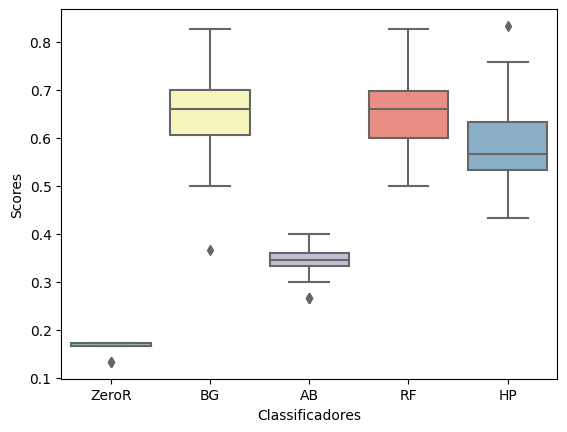

In [281]:
method_names = ['ZeroR', 'BG', 'AB', 'RF', 'HP']

sns.boxplot(data=scores_list, palette="Set3").set(xticklabels=method_names)
plt.xlabel("Classificadores")
plt.ylabel("Scores")

plt.show()